# Histopathologic Cancer Detection
Identify based on the provided pathology images, create a model to identify if it contains a pixel of tumor tissue

## About Dataset
The provided dataset is a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. The model need to predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.



In [1]:


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

from PIL import Image
from PIL import ImageDraw

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, datasets


2024-04-09 03:18:54.938144: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 03:18:54.938326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 03:18:55.120684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_train = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df_sample = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

#df_train = df_train[0:100]
#df_sample = df_sample[0:100]
print(df_sample.head())
print(f'Train Data Shape: {df_train.shape}')
print(f'Test Data Shape: {df_sample.shape}')


                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0
Train Data Shape: (220025, 2)
Test Data Shape: (57458, 2)


In [3]:
train = "/kaggle/input/histopathologic-cancer-detection/train/"
test = "/kaggle/input/histopathologic-cancer-detection/test"

print("Number of training images: {}".format(len(os.listdir(train))))
print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


##  Data Exploratory (EDA)

In [4]:
def print_short_summary(name, data):
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2. Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()
    
def print_number_files(dirpath):
    print('{}: {} files'.format(dirpath, len(os.listdir(dirpath))))

In [5]:
print_short_summary('Train data', df_train)

Train data

1. Data head:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

2. Data shape: (220025, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [6]:
print_short_summary('Sample data', df_sample)

Sample data

1. Data head:
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

2. Data shape: (57458, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


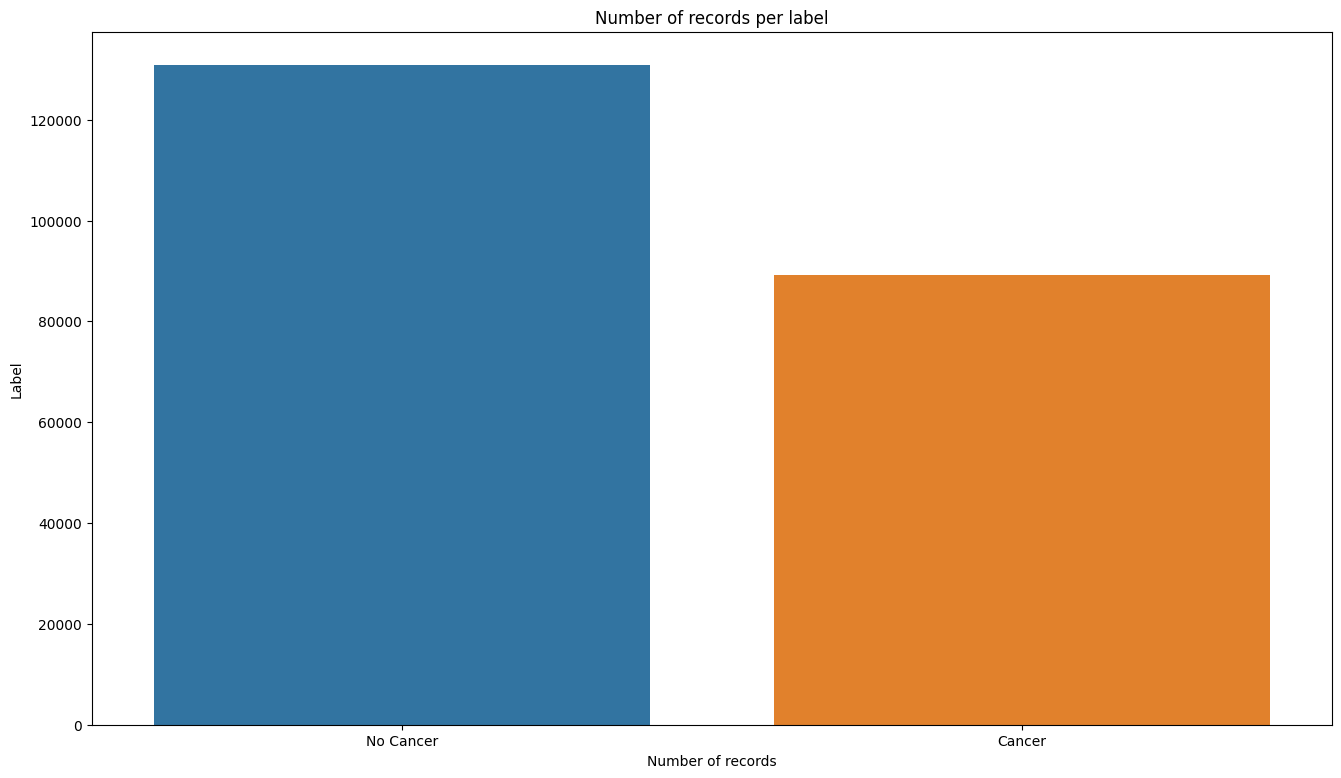

In [7]:
plt.figure(figsize=(16, 9))
count_per_label = df_train['label'].value_counts()
sns.barplot(x=['No Cancer', 'Cancer'], y=count_per_label.values, orient='v')
plt.xlabel('Number of records')
plt.ylabel('Label')
plt.title('Number of records per label')
plt.show()

In [8]:
cancer_cases = df_train.loc[df_train['label']==1]['id'].values 
nocancer_cases = df_train.loc[df_train['label']==0]['id'].values 

print(f'Sample Cancer Images: \n{cancer_cases}')
print(f'---------------------------------------------')
print(f'Sample Non-Cancer Images: \n{nocancer_cases}')

Sample Cancer Images: 
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f' ...
 '309210db7f424edbc22b2d13bf2fa27518b18f5c'
 'd4b854fe38b07fe2831ad73892b3cec877689576'
 'a81f84895ddcd522302ddf34be02eb1b3e5af1cb']
---------------------------------------------
Sample Non-Cancer Images: 
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08' ...
 '53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6'
 '3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75'
 'f129691c13433f66e1e0671ff1fe80944816f5a2']


In [9]:
def plot_fig(ids,title,nrows=3,ncols=3):

    fig,ax = plt.subplots(nrows,ncols,figsize=(7,7))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(train ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)
    


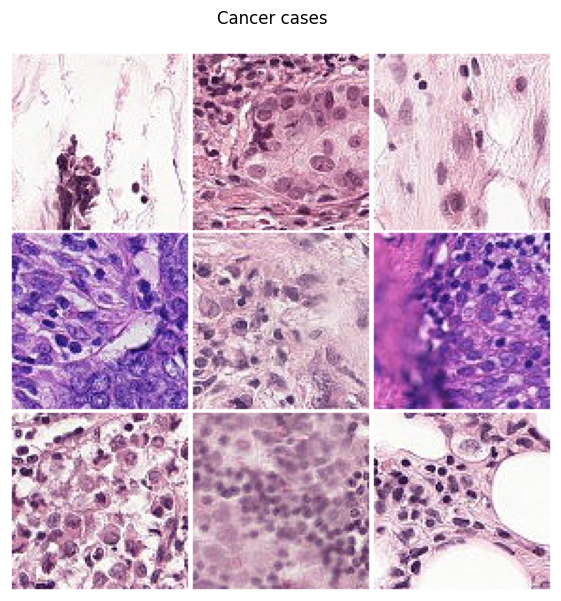

In [10]:
plot_fig(cancer_cases,'Cancer cases')

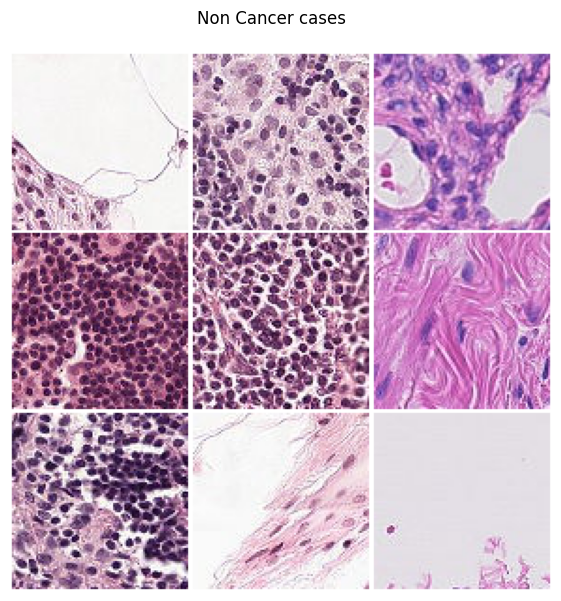

In [11]:
plot_fig(nocancer_cases,'Non Cancer cases')

## Images Extraction

In [12]:
df_train['id'] += '.tif'
df_sample['id'] += '.tif'

print(f'Train: {df_train.head()}')

print(f'Sample: {df_sample.head()}')

Train:                                              id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0
Sample:                                              id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif      0
1  95596b92e5066c5c52466c90b69ff089b39f2737.tif      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914.tif      0
3  2c35657e312966e9294eac6841726ff3a748febf.tif      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif      0


### Training Image

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

df_train = df_train.astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory = train,
    x_col = 'id',
    y_col = 'label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)


Found 220025 validated image filenames belonging to 2 classes.


### Sample Image

In [14]:
sample_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

df_sample = df_sample.astype(str)

test_generator = sample_datagen.flow_from_dataframe(
    dataframe= df_sample,
    directory = test,
    x_col = 'id',
    y_col = 'label',
    target_size=(96,96),
    batch_size=32
)


Found 57458 validated image filenames belonging to 1 classes.


## Model Building

In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')
    
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
#model.compile(loss=tf.keras.losses.binary_crossentropy,
  #            optimizer=tf.keras.optimizers.Adam(0.001), 
  #            metrics=['accuracy'])

# Train the model
#model.fit(train_generator, df_train['label'], epochs=10, validation_data=(test_generator, df_sample['label']))
#model.fit(train_generator, epochs=10, validation_data=test_generator)



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [16]:
model.fit(train_generator, epochs=1, validation_data=test_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6876/6876 ━━━━━━━━━━━━━━━━━━━━ 3417s 496ms/step - accuracy: 0.7803 - loss: 0.4659 - val_accuracy: 0.3447 - val_loss: 1.4731


In [17]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,571,752 (9.81 MB)

 Trainable params: 857,250 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,714,502 (6.54 MB)

In [18]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_accuracy, 'test loss:', test_loss)

1796/1796 - 364s - 202ms/step - accuracy: 0.3444 - loss: 1.4717

Test accuracy: 0.3444080948829651 test loss: 1.4716659784317017


In [19]:
model.save('/kaggle/working/model.keras')

In [20]:
# Predict
test_predictions = model.predict(test_generator, verbose=2)


1796/1796 - 368s - 205ms/step


In [21]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/kaggle/working/model.keras')

# Use the model for inference
#predictions = model.predict(input_data)

In [22]:
print(f'test_predictions: {test_predictions[0:5]}')
print(f'test_generator.filenames: {len(test_generator.filenames)}')
print(f'test_predictions.flatten: {len(test_predictions.flatten())}')
print(f'test_predictions - 0: {np.argmax(test_predictions[0])}')
print(f'test_predictions - 1: {np.argmax(test_predictions[1])}')

test_predictions: [[0.81211513 0.44929716]
 [0.98125684 0.44817892]
 [0.4619228  0.8636633 ]
 [0.8973409  0.29563528]
 [0.93637824 0.30636507]]
test_generator.filenames: 57458
test_predictions.flatten: 114916
test_predictions - 0: 0
test_predictions - 1: 0


In [23]:

#test_df= pd.DataFrame({'id':  test_generator.filenames,'label': np.argmax(test_predictions)})
test_df = pd.DataFrame({
    'id': test_generator.filenames,
    'label': [np.argmax(pred) for pred in test_predictions]
})
test_df[0:5]

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,1
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [24]:

# Get rid of '.tif' in 'id' column
def extract_id(x):
    #print(x)
    b = x.split('.')
    extracted_id = b[0]
    #print(extracted_id)
    
    return extracted_id

test_df['id'] = test_df['id'].apply(extract_id)

test_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,1
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [25]:
test_df.to_csv('submission.csv', index=False)